In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow.keras import layers

c:\Users\megav\anaconda3\envs\iml-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/data0/lsun/bedroom",
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='grayscale',
    batch_size=None,
    image_size=(128, 128),
    shuffle=True,
    seed=2024,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 303125 files belonging to 1 classes.


In [52]:
len(list(dataset))

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
IMG_SIZE = 128   # input image size
BATCH_SIZE = 4  # for training batch size
timesteps = 64    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

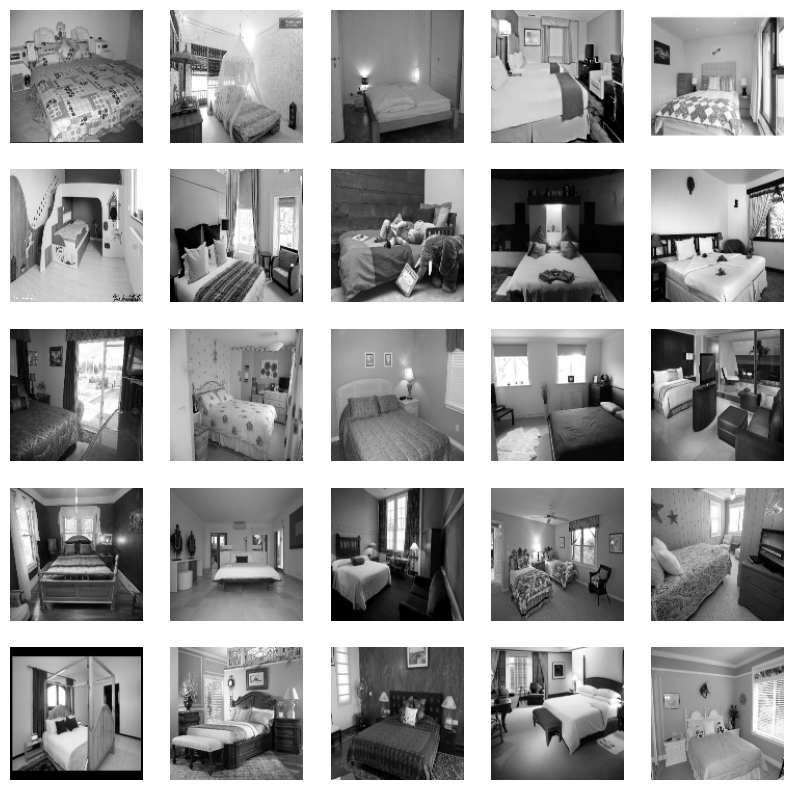

In [4]:
# from PIL import Image
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_numpy_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(x.shape[0]):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

show_numpy_examples(np.array(list(dataset.take(25))))

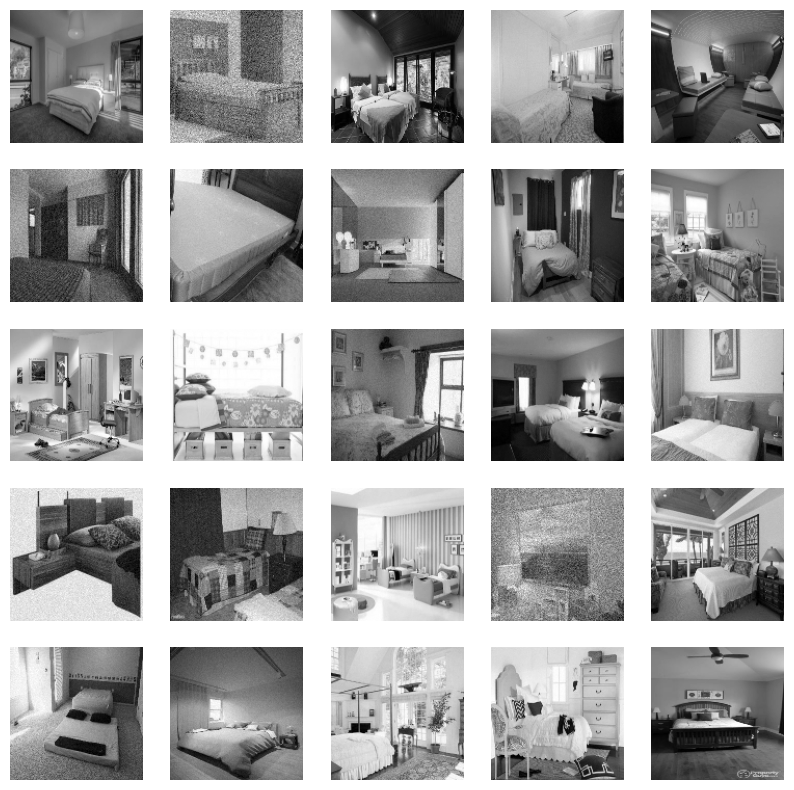

In [5]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
a, b = forward_noise(np.array(list(dataset.take(25))), t)
show_numpy_examples(a)

In [6]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

In [7]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x4 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(16 * 16 * 128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((16, 16, 128))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(1, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
# model.summary()

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

100%|██████████| 64/64 [00:12<00:00,  5.11it/s]


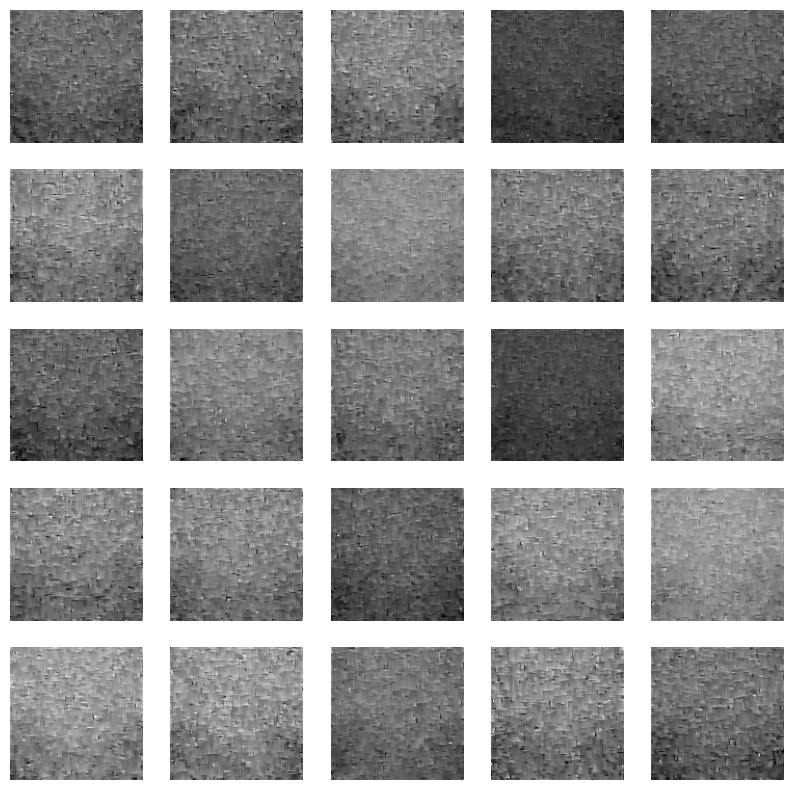

In [24]:
def predict(n=32):
    x = np.random.normal(size=(n, IMG_SIZE, IMG_SIZE, 1))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((n), t)], verbose=0)
    show_numpy_examples(x)

predict(25)

100%|██████████| 64/64 [00:06<00:00, 10.07it/s]


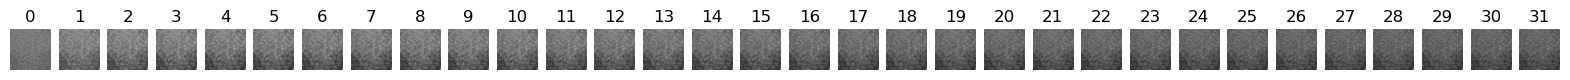

In [18]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 1))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]), cmap='gray')
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [15]:
def train_one(x_img):
    # print(x_img.shape)
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    # print(x_a.shape)
    # print(x_b.shape)
    # print(x_ts.shape)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [16]:
# loss_history = []

def train(dataset):
    total = dataset.cardinality().numpy()
    bar = trange(total)
    # print(bar)
    batch_iterator = iter(dataset)
    for i in bar:
        batch = next(batch_iterator)
        loss = train_one(batch.numpy())
        # loss_history.append(loss)
        pg = (i / total) * 100
        bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

# dataset8 = dataset.batch(4)
# train(dataset8)

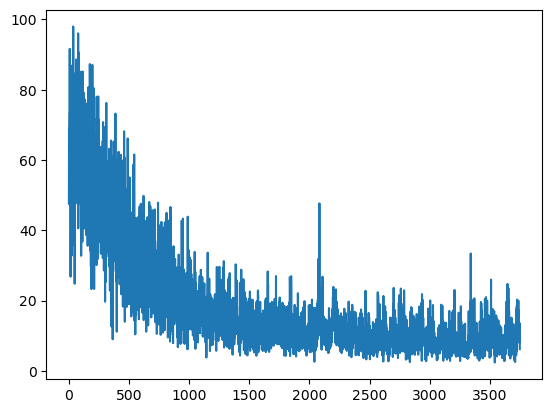

In [30]:
plt.plot(loss_history)
# plt.title('Training loss')


loss: 0.47858, p: 100.00%: 100%|██████████| 75782/75782 [1:46:41<00:00, 11.84it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.00071999995>


100%|██████████| 64/64 [00:03<00:00, 20.47it/s]


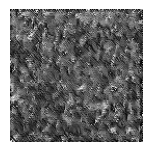

loss: 0.54884, p: 100.00%: 100%|██████████| 75782/75782 [1:45:52<00:00, 11.93it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0006479999>


100%|██████████| 64/64 [00:03<00:00, 20.30it/s]


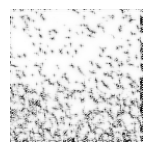

loss: 0.13929, p: 100.00%: 100%|██████████| 75782/75782 [1:42:40<00:00, 12.30it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0005831999>


100%|██████████| 64/64 [00:03<00:00, 21.11it/s]


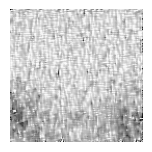

loss: 0.14453, p: 100.00%: 100%|██████████| 75782/75782 [1:42:39<00:00, 12.30it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0005248799>


100%|██████████| 64/64 [00:03<00:00, 20.87it/s]


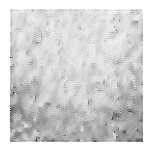

loss: 0.68650, p: 100.00%: 100%|██████████| 75782/75782 [1:42:19<00:00, 12.34it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0004723919>


100%|██████████| 64/64 [00:03<00:00, 21.11it/s]


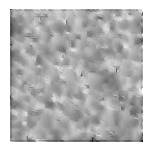

loss: 0.11987, p: 100.00%: 100%|██████████| 75782/75782 [1:42:04<00:00, 12.37it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.00042515268>


100%|██████████| 64/64 [00:03<00:00, 21.08it/s]


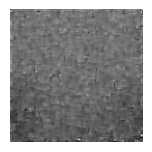

loss: 0.85218, p: 100.00%: 100%|██████████| 75782/75782 [1:42:21<00:00, 12.34it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0003826374>


100%|██████████| 64/64 [00:03<00:00, 20.91it/s]


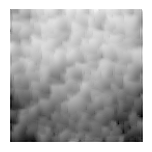

loss: 0.65386, p: 100.00%: 100%|██████████| 75782/75782 [1:42:53<00:00, 12.27it/s]


<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.00034437366>


100%|██████████| 64/64 [00:03<00:00, 20.21it/s]


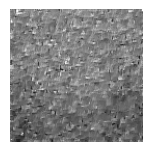

loss: 0.91350, p: 0.17%:   0%|          | 132/75782 [00:11<1:53:59, 11.06it/s]


KeyboardInterrupt: 

In [17]:
dataset_batched = dataset.batch(BATCH_SIZE)

for _ in range(20):
    train(dataset_batched)
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)
    print(model.optimizer.learning_rate)

    # show result 
    predict(1)
    # predict_step()
    plt.show()

In [23]:
# model.save_weights('./checkpoints/gray_7_epochs')

# # Create a new model instance
# model = make_model()

# Restore the weights
model.load_weights('./checkpoints/gray_7_epochs')
